In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import cirq
from mitiq import cdr
import mitiq

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))


import numpy as np
from scipy.optimize import minimize
import networkx as nx

import qiskit 
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from shared.QiskitMaxcut import *
from qiskit.utils import QuantumInstance
from qiskit.result import Result
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, QNSPSA
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
%matplotlib inline

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')

In [3]:
%load_ext autoreload
%autoreload 2

## Clifford data regression Example

https://mitiq.readthedocs.io/en/stable/examples/cdr_api.html

In [4]:
a, b = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.rx(0.1).on(a),
    cirq.rx(-0.72).on(b),
    cirq.rz(0.4).on(a),
    cirq.rz(0.2).on(b),
    cirq.CNOT.on(a, b),
    cirq.rx(-0.1).on(b),
    cirq.rz(-0.23).on(a),
    cirq.CNOT.on(b, a),
    cirq.rx(-0.112).on(a),
    cirq.measure(a, b, key="z"),
)
circuit

0: ───Rx(0.032π)────Rz(0.127π)───@───Rz(-0.073π)───X───Rx(-0.036π)───M('z')───
                                 │                 │                 │
1: ───Rx(-0.229π)───Rz(0.064π)───X───Rx(-0.032π)───@─────────────────M────────

In [5]:
from typing import Counter


def sample_bitstrings(circ: cirq.Circuit, shots: int = 1000, noise: float = 0.01) -> Counter[int]:
    # Add depolarizing noise to emulate a noisy quantum processor!
    circuit = circ.with_noise(cirq.depolarize(noise))
    
    return cirq.DensityMatrixSimulator().run(circuit, repetitions=shots).histogram(key="z")

In [6]:
sample_bitstrings(circuit)

Counter({0: 760, 3: 182, 2: 28, 1: 30})

In [7]:
# Observable(s) to measure.
z = np.diag([1, -1])
obs = np.diag(np.kron(z, z))

In [8]:
def sample_bitstrings_simulator(circuit, shots: int = 1000) -> Counter:
    return sample_bitstrings(circuit, shots=shots, noise=0.0)

In [9]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings_simulator(circuit),
    observable=obs,
)

0.992

In [10]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings(circuit),
    observable=obs,
)

0.858

In [11]:
cdr.execute_with_cdr(
    circuit=circuit,
    executor=sample_bitstrings,
    observables=[obs],
    simulator=sample_bitstrings_simulator,
)

[0.99]

Circuit

In [12]:
def generate_sample_graph(with_weights=True):
    # Generate a graph of 5 nodes
    # filename = graph_05_06_02_w.txt
    n = 4
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    elist = [(0, 1, 1), (1, 2, 1), (2, 3, 1), (3, 0, 1)]
    graph.add_weighted_edges_from(elist)
    
    return graph

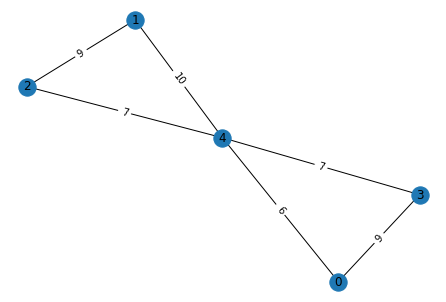

In [12]:
#G = generate_sample_graph() 
from ibm.ibm_parameters import *
G = generate_butterfly_graph(with_weights=True)

#G = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(G,-35)
max_cut.draw()
qubo = max_cut.to_qubo()

### Create Circuit 

In [34]:
qaoa = QAOA(quantum_instance=Aer.get_backend('qasm_simulator'), initial_point=[ -3.33412359,  5.45892711])
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(qubo)
param_dict = dict(zip(qaoa._ansatz_params, qaoa._initial_point))  # type: Dict
wave_function = qaoa.ansatz.assign_parameters(param_dict)

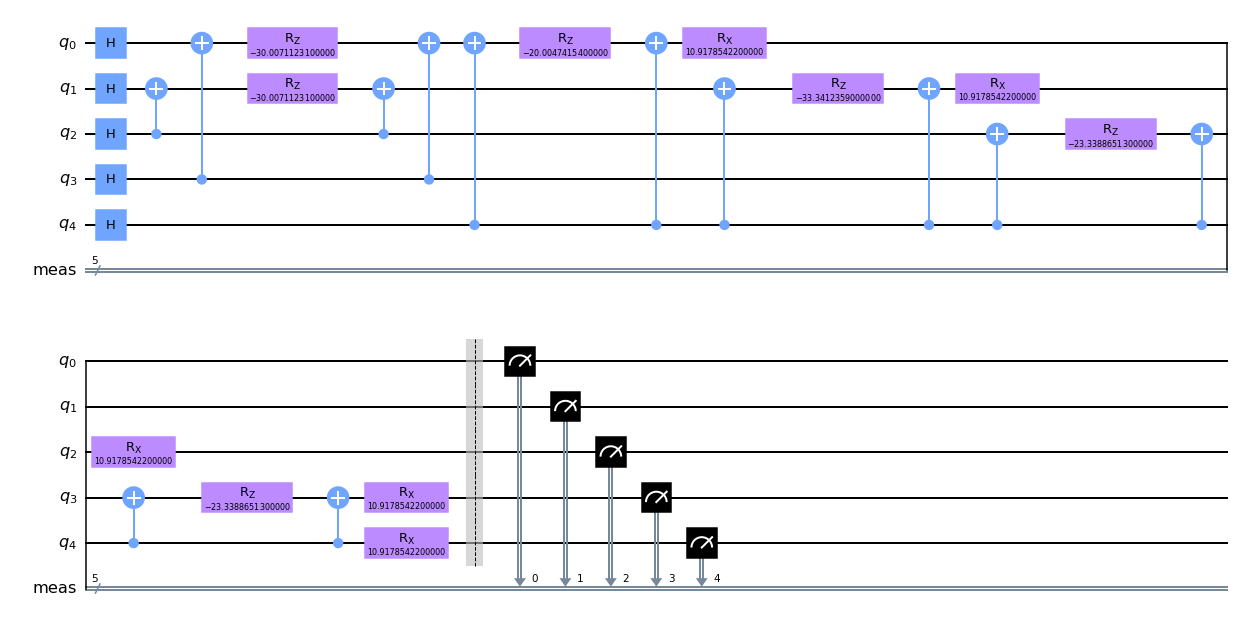

In [59]:
circuit = wave_function.copy()
circuit.measure_all()
circuit.draw('mpl')

In [36]:
# todo: maybe convert to specific gates 

In [50]:
import qiskit 
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

noise_backend = provider.get_backend("ibmq_toronto")
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

def sample_bitstrings(circuit, shots: int = 1024) -> Dict[int, int]:
    # Add depolarizing noise to emulate a noisy quantum processor!
    # Use Aer's qasm_simulator
    print("run noise")
    circuit.name = ""
    if type(circuit) == cirq.circuits.circuit.Circuit:
        circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)

    backend_sim = Aer.get_backend('qasm_simulator')
    qi = QuantumInstance(backend=backend_sim,shots=shots, noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates)
    result = qi.execute(circuit)

    counts = result.get_counts()
    int_counts = {}
    for key in counts.keys():
        int_counts[int(key.replace(' ',''),2)] = counts[key]
    return int_counts

run noise


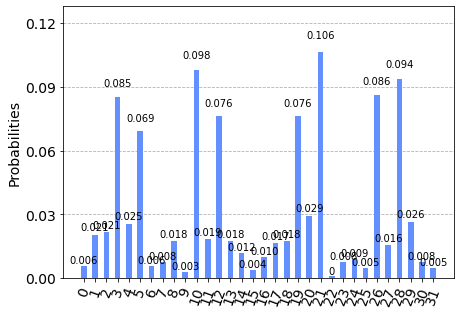

In [51]:
plot_histogram(sample_bitstrings(circuit))

In [52]:
def sample_bitstrings_simulator(circuit, shots: int = 1024) -> Dict[int, int]:
    # Use Aer's qasm_simulator
    print("run simulator")
    circuit.name = ""

    if type(circuit) == cirq.circuits.circuit.Circuit:
        circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)

    backend_sim = Aer.get_backend('qasm_simulator')
    qi = QuantumInstance(backend=backend_sim,shots=shots)
    result = qi.execute(circuit)

    counts = result.get_counts()

    int_counts = {}
    for key in counts.keys():
        int_counts[int(key.replace(' ',''),2)] = counts[key]
    return int_counts

run simulator


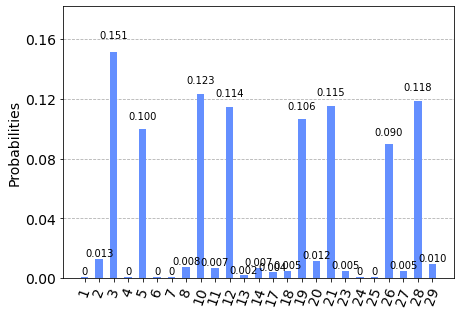

In [53]:
plot_histogram(sample_bitstrings_simulator(circuit))

In [60]:
# Observable(s) to measure.
operator, offset = qubo.to_ising()
print(f"offest: {offset}")
obs = np.real(np.diag(operator.to_matrix()))
obs

offest: -24.0


array([ 24.,   9.,   5., -10.,   8.,  -7.,   7.,  -8.,   8.,  11., -11.,
        -8.,  -8.,  -5.,  -9.,  -6.,  -6.,  -9.,  -5.,  -8.,  -8., -11.,
        11.,   8.,  -8.,   7.,  -7.,   8., -10.,   5.,   9.,  24.])

In [55]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings_simulator(circuit),
    observable=obs,
)

run simulator


-8.3544921875

In [56]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings(circuit),
    observable=obs,
)

run noise


-6.1845703125

In [57]:
exp = cdr.execute_with_cdr(
    circuit=circuit,
    executor=sample_bitstrings,
    observables=[obs],
    simulator=sample_bitstrings_simulator,
)
exp

run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run simulator


[-6.765625]

In [62]:
# add offset -> real expectation value?
exp[0] + offset

-30.765625

In [45]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

noise_backend = provider.get_backend("ibmq_toronto")
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [28]:
qiGME = QuantumInstance(backend=Aer.get_backend('qasm_simulator'),  shots=1024)

In [29]:
qaoa = CDR_QAOA(quantum_instance=qiGME, reps=1, initial_point=[0.1,0.1], optimizer=COBYLA(maxiter=100))
result = MinimumEigenOptimizer(qaoa).solve(qubo)
mean, r, ar = max_cut.analyse_evaluation(result, print_output=True)

run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Number of samples (31) is too large to display. Skip.
Expectation Value: -22.1865234375
Highest Exp.Value: 0 with 10.449 %
Lowest Exp.Value: -35 with 4.0039 %
Highest Probability: -16 with 28.418 %
Ratio r: 0.634
Approiximatio

In [30]:
from shared.cdr.cdr_qaoa import CDR_QAOA

In [31]:
qiGME = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), noise_model=noise_model, coupling_map=coupling_map,basis_gates=basis_gates,   shots=1024)

In [32]:
qaoa = CDR_QAOA(quantum_instance=qiGME, reps=1, initial_point=[0.1,0.1], optimizer=COBYLA(maxiter=100))
result = MinimumEigenOptimizer(qaoa).solve(qubo)
mean, r, ar = max_cut.analyse_evaluation(result, print_output=True)

run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
run noise
run simulator
optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -26.21484375
Highest Exp.Value: 0 with 5.3711 %
Lowest Exp.Value: -35 with 7.6172 %
Highest Probability: -32 with 22.949 %
Ratio r: 0.749
Approiximation ratio: 0.749
MSE: 114.70841745229868
RMSE: 10.710201559835308


In [61]:
qiGME = QuantumInstance(backend=Aer.get_backend('qasm_simulator'),
                                                       noise_model=noise_model, 
                               coupling_map=coupling_map,
                               basis_gates=basis_gates,
                               shots=1024)
qaoa = QAOA(quantum_instance=qiGME, reps=1, initial_point=[0.1,0.1], optimizer=COBYLA(maxiter=10))
result = MinimumEigenOptimizer(qaoa).solve(qubo)
mean, r, ar = max_cut.analyse_evaluation(result, print_output=True)

optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -27.0751953125
Highest Exp.Value: 0 with 2.4414000000000002 %
Lowest Exp.Value: -35 with 9.1797 %
Highest Probability: -32 with 24.023 %
Ratio r: 0.774
Approiximation ratio: 0.774
MSE: 120.31860505617581
RMSE: 10.968983774998293


In [54]:
# Copyright (C) 2021 Unitary Fund
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

"""API for using Clifford Data Regression (CDR) error mitigation."""

from functools import wraps
from typing import Any, Callable, cast, List, Optional, Sequence, Tuple, Union

import numpy as np
from scipy.optimize import curve_fit

from cirq import Circuit

from mitiq.interface import accept_any_qprogram_as_input

from mitiq.cdr import (
    generate_training_circuits,
    linear_fit_function,
    linear_fit_function_no_intercept,
)
from mitiq.cdr.execute import calculate_observable, MeasurementResult
from mitiq.zne.scaling import fold_gates_at_random


@wraps(accept_any_qprogram_as_input)
def execute_with_cdr(
    circuit: Circuit,
    executor: Callable[[Circuit], MeasurementResult],
    simulator: Callable[[Circuit], Union[MeasurementResult, np.ndarray]],
    observables: List[np.ndarray],
    num_training_circuits: int = 10,
    fraction_non_clifford: float = 0.1,
    fit_function: Callable[..., float] = linear_fit_function,
    num_fit_parameters: Optional[int] = None,
    scale_factors: Sequence[float] = (1,),
    scale_noise: Callable[[Circuit, float], Circuit] = fold_gates_at_random,
    full_output: bool = False,
    **kwargs: Any,
) -> Union[List[float], Tuple[List[float], np.ndarray]]:
    """Function for the calculation of an observable from some circuit of
    interest to be mitigated with CDR (or vnCDR) based on [Czarnik2020]_ and
    [Lowe2020]_.
    The circuit of interest must be compiled in the native basis of the IBM
    quantum computers, that is {Rz, sqrt(X), CNOT}, or such that all the
    non-Clifford gates are contained in the Rz rotations.
    The observable/s to be calculated should be input as an array or a list of
    arrays representing the diagonal of the observables to be measured. Note
    these observables MUST be diagonal in z-basis measurements corresponding to
    the circuit of interest.
    Returns mitigated observables list of raw observables (at noise scale
    factors).
    This function returns the mitigated observable/s.
    Args:
        circuit: Circuit of interest compiled in the correct basis.
        executor: User defined function taking a cirq Circuit object and
                  returning a dictionary of counts.
        simulator: User defined function taking a cirq Circuit object and
                   returning either a simulated dictionary of counts or an
                   np.ndarray representing the state vector.
        observables: List of arrays containing the diagonal elements of
                    observable/s of interest to be mitigated. If a list is
                    passed all these observables will be mitigates with the
                    same training set.
        num_training_circuits: Number of training circuits to be used in the
                               mitigation.
        fraction_non_clifford: The fraction of non-Clifford gates to be
                               substituted in the training circuits. The higher
                               this fraction the more costly the simulations,
                               but more successful the mitigation.
        fit_function: The function to map noisy to exact data. Takes array of
                      noisy and data and parameters returning a float.
        num_fit_parameters: The number of parameters the fit_function takes.
        scale_noise: Optional argument containing a user defined function on
                     how to increase the noise. If this argument is given then
                     the mitigation method will be vnCDR.
        scale_factors: Factors by which to scale the noise, should not
                               include 1 as this is just the original circuit.
        full_output: If True, returns ⟨𝛹| O |𝛹⟩ for each training circuit
            |𝛹⟩ (including the original circuit) and each observable O. The
            ith row of this 2d array corresponds to the ith observable, and
            the jth column corresponds to the jth training circuit.
        kwargs: Available keyword arguments are:
            - method_select (string): Specifies the method used to select the
                non-Clifford gates to replace when constructing the
                near-Clifford training circuits. Can be 'uniform' or
                'gaussian'.
            - method_replace (string): Specifies the method used to replace
                the selected non-Clifford gates with a Clifford when
                constructing the near-Clifford training circuits. Can be
                'uniform', 'gaussian', or 'closest'.
            - sigma_select (float): Width of the Gaussian distribution used for
                ``method_select='gaussian'``.
            - sigma_replace (float): Width of the Gaussian distribution used
                for ``method_replace='gaussian'``.
            - random_state (int): Seed for sampling.
    Returns: A list of error mitigated observable expectation values. If
        full_output is True, also returns the observable expectation values
        for each training circuit (see above).
    .. [Czarnik2020] : Piotr Czarnik, Andrew Arramsmith, Patrick Coles,
        Lukasz Cincio, "Error mitigation with Clifford quantum circuit
        data," (https://arxiv.org/abs/2005.10189).
    .. [Lowe2020] : Angus Lowe, Max Hunter Gordon, Piotr Czarnik,
        Andrew Arramsmith, Patrick Coles, Lukasz Cincio,
        "Unified approach to data-driven error mitigation,"
        (https://arxiv.org/abs/2011.01157).
    """
    # Handle keyword arguments for generating training circuits.
    method_select = kwargs.get("method_select", "uniform")
    method_replace = kwargs.get("method_replace", "closest")
    random_state = kwargs.get("random_state", None)
    kwargs_for_training_set_generation = {
        "sigma_select": kwargs.get("sigma_select"),
        "sigma_replace": kwargs.get("sigma_replace"),
    }

    if num_fit_parameters is None and fit_function not in (
        linear_fit_function,
        linear_fit_function_no_intercept,
    ):
        raise ValueError(
            "Must provide arg `num_fit_parameters` for custom fit function."
        )
    num_fit_parameters = cast(int, num_fit_parameters)

    # Generate training circuits.
    training_circuits = generate_training_circuits(
        circuit,
        num_training_circuits,
        fraction_non_clifford,
        method_select,
        method_replace,
        random_state,
        kwargs=kwargs_for_training_set_generation,
    )

    # [Optionally] Scale noise in circuits.
    all_circuits = [
        [scale_noise(c, s) for s in scale_factors]
        for c in [circuit] + training_circuits  # type: ignore
    ]

    # Execute all circuits to get MeasurementResult's. TODO: Allow batching.
    noisy_counts = np.array(
        [[executor(circ) for circ in circuits] for circuits in all_circuits]
    )
    ideal_counts = np.array([simulator(circ) for circ in all_circuits[0]])

    results_dict_circuit_of_interest = noisy_counts[:, 0]

    mitigated_observables = []
    raw_observables = []
    for obs in observables:
        circuit_data = np.array(
            [
                calculate_observable(measurements, obs)
                for measurements in results_dict_circuit_of_interest
            ]
        )
        raw_observables.append(list(circuit_data))

        # Get the noisy ⟨𝛹| O |𝛹⟩ from the noisy (executor) counts.
        noisy_expectation_values = np.array(
            [
                [
                    calculate_observable(measurements, obs)
                    for measurements in row
                ]
                for row in noisy_counts
            ]
        )

        # Get the exact ⟨𝛹| O |𝛹⟩ from the exact (simulator) counts.
        ideal_expectation_values = np.array(
            [
                calculate_observable(
                    state_or_measurements=measurements, observable=obs
                )
                for measurements in ideal_counts
            ]
        )

        # Do the regression.
        fitted_params, _ = curve_fit(
            lambda x, *params: fit_function(x, params),
            noisy_expectation_values,
            ideal_expectation_values,
            p0=np.zeros(num_fit_parameters),
        )
        mitigated_observables.append(fit_function(circuit_data, fitted_params))

    if not full_output:
        return mitigated_observables, fitted_params
    return mitigated_observables, np.array(raw_observables)



@wraps(accept_any_qprogram_as_input)
def execute_with_cdr_2(
    fitted_params,
    circuit: Circuit,
    executor: Callable[[Circuit], MeasurementResult],
    simulator: Callable[[Circuit], Union[MeasurementResult, np.ndarray]],
    observables: List[np.ndarray],
    num_training_circuits: int = 10,
    fraction_non_clifford: float = 0.1,
    fit_function: Callable[..., float] = linear_fit_function,
    num_fit_parameters: Optional[int] = None,
    scale_factors: Sequence[float] = (1,),
    scale_noise: Callable[[Circuit, float], Circuit] = fold_gates_at_random,
    full_output: bool = False,
    **kwargs: Any,
) -> Union[List[float], Tuple[List[float], np.ndarray]]:

 
    method_select = kwargs.get("method_select", "uniform")
    method_replace = kwargs.get("method_replace", "closest")
    random_state = kwargs.get("random_state", None)
    kwargs_for_training_set_generation = {
        "sigma_select": kwargs.get("sigma_select"),
        "sigma_replace": kwargs.get("sigma_replace"),
    }

    if num_fit_parameters is None and fit_function not in (
        linear_fit_function,
        linear_fit_function_no_intercept,
    ):
        raise ValueError(
            "Must provide arg `num_fit_parameters` for custom fit function."
        )
    num_fit_parameters = cast(int, num_fit_parameters)

    # Generate training circuits.
    training_circuits = []

    # [Optionally] Scale noise in circuits.
    all_circuits = [
        [scale_noise(c, s) for s in scale_factors]
        for c in [circuit] + training_circuits  # type: ignore
    ]

    # Execute all circuits to get MeasurementResult's. TODO: Allow batching.
    noisy_counts = np.array(
        [[executor(circ) for circ in circuits] for circuits in all_circuits]
    )
    #ideal_counts = np.array([simulator(circ) for circ in all_circuits[0]])

    results_dict_circuit_of_interest = noisy_counts[:, 0]
    mitigated_observables = []
    raw_observables = []
    for obs in observables:
        circuit_data = np.array(
            [
                calculate_observable(measurements, obs)
                for measurements in results_dict_circuit_of_interest
            ]
        )
        
        mitigated_observables.append(fit_function(circuit_data, fitted_params))

    if not full_output:
        return mitigated_observables, fitted_params
    return mitigated_observables, np.array(raw_observables)

In [27]:
o, f = execute_with_cdr(
    circuit=circuit,
    executor=sample_bitstrings,
    observables=[obs],
    simulator=sample_bitstrings_simulator,
)
o

run noisee
run noisee
run noisee
run noisee
run noisee
run noisee
run noisee
run noisee
run noisee
run noisee
run noisee
run simulator


[0.05273437500000001]

In [28]:
execute_with_cdr_2(
    f,
    circuit=circuit,
    executor=sample_bitstrings,
    observables=[obs],
    simulator=sample_bitstrings_simulator,
)

run noisee


([0.05198317307692308], array([0.05128205]))